### Difference Image Network - PyTorch

### Imports

In [1]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [2]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)
    
with open('datasets/tmaze_random_reverse_data.pickle', 'rb') as handle:
    tmaze_random_reverse_data = pickle.load(handle)
    
with open('datasets/oracle_reversed_random_data_small.pickle', 'rb') as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

### Plot example diff. image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actions  [2, 2]
position  [7.901, 22.886]


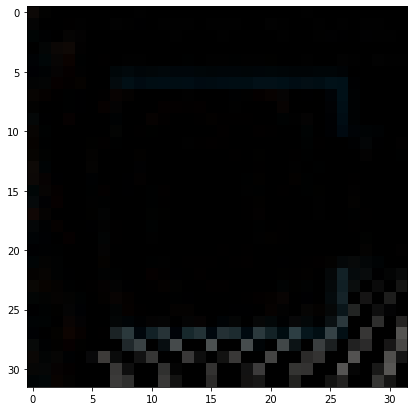

In [3]:
distance = 2
plot.plot_difference_img(oracle_data, distance)

### Preprocess data

In [4]:
n = 4
# change seq. length, recode actions, split dataset
dataset = preprocess.split_n_steps_between(oracle_reversed_random_data_small, n=n)
dataet, counter = preprocess.recode_actions(dataset, n)
train_data, test_data = preprocess.split_data(dataset, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDualDataset(train_data, 'observationsA','observationsB', 'actions')
oracle_test_data = preprocess.ObtainDualDataset(test_data, 'observationsA','observationsB', 'actions')

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

### Inspect overlap of train and val. set in terms of classes

In [5]:
n_overlap = tools.determine_overlap_train_test_data(train_data, test_data)
print('Elements where class is in both train and test data:', n_overlap)

total train data: 2397
total test data: 599
Elements where class is in both train and test data: 2309


### Two images within one batch & connecting action

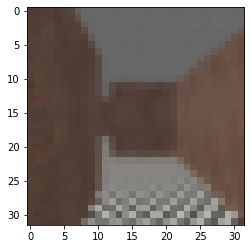

[146]


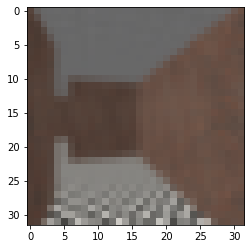

In [7]:
import torchvision
import torch
from matplotlib import pyplot as plt

classes_expl = {0: 'turn left', 1: 'turn right', 2: 'walk forwards', 3: 'walk backwards'}

index = 560

imageA = dataset['observationsA'][index]
imageB = dataset['observationsB'][index]

plt.imshow(imageA)
plt.show()

print(dataset['actions'][index])

plt.imshow(imageB)
plt.show()

### Initialize the model

In [8]:
forward = nets.Forward(counter) # FC-Feed-forward network
summary(forward, (3,32,32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                  [-1, 256]          21,760
Total params: 82,916
Trainable params: 82,916
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.32
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [9]:
import torch
import plot
from tqdm.auto import tqdm

import torchvision
from torch.utils.tensorboard import SummaryWriter

def train(train_data, val_data, net, criterion, optimizer, steps):
    '''
    Main training loop
    Input: dataset_loader, network, training_loss, optimizer, step size
    Output: trained network
    '''

    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    with tqdm(total=steps, unit =" Episode", desc ="Progress") as pbar:
        for epoch in range(steps):  # loop over the dataset multiple times

            train_running_loss = 0.0

            train_correct = 0
            train_total = 0

            for i, data in enumerate(train_data, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputsA, inputsB, labels = data
                labels = labels[0]
                labels = labels.to(torch.long)
                
                inputs = inputsB - inputsA

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # compute acc
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # track loss statistics
                train_running_loss += loss.item()

                test_running_loss = 0.0

                test_correct = 0
                test_total = 0

                # same for validation set
                with torch.no_grad():
                    for data in val_data:
                        inputsA, inputsB, labels = data
                        labels = labels[0]
                        labels = labels.to(torch.long)
                        
                        inputs = inputsB - inputsA
                        
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
                        test_running_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        test_total += labels.size(0)
                        test_correct += (predicted == labels).sum().item()

            train_loss.append(train_running_loss/len(train_data))
            test_loss.append(test_running_loss/len(val_data))
            train_acc.append(100 * train_correct / train_total)
            test_acc.append(100 * test_correct / test_total)
            pbar.update(1)

            if epoch % 10 == 0:
                print(f'Epoch: {epoch + 1}, Train Loss: {(train_running_loss/len(train_data)):.4}, Train Acc: {(100 * train_correct / train_total):.4} %,  Test Loss: {(test_running_loss/len(val_data)):.4}, Test Acc: {(100 * test_correct / test_total):.4} %,')

    print('Finished Training')
    return net, train_loss, test_loss, train_acc, test_acc

ModuleNotFoundError: No module named 'plot'

### Train model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(forward.parameters(), lr=0.001) #, momentum=0.9) # for small one 0.01 works well

episodes = 500
forward, train_loss, test_loss, train_acc, test_acc  = train(dataset_loader_train_data, dataset_loader_test_data, forward, criterion, optimizer, episodes)

### Plot loss and accuracy curves for training and test set

In [ ]:
plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=False)

In [ ]:
def plot_losses(test_loss, train_loss):
    with plt.style.context('ggplot'):
        plt.figure(figsize=(12, 7))
        #plt.style.use('ggplot')
        plt.rcParams.update({'font.size': 16})
        plt.plot(test_loss, color='slategray', linewidth=2)
        plt.plot(train_loss, color='red', linewidth=2)
        plt.legend(['Training Loss', 'Validation Loss'])
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.show()

def plot_acc(test_acc, train_acc, smooth=False):

    if smooth:
        test_acc_smoothed = savgol_filter(test_acc, 30, 12)  # window size, polynomial order
        train_acc_smoothed = savgol_filter(train_acc, 30, 12)

    with plt.style.context('ggplot'):
        plt.figure(figsize=(12, 7))
        #plt.style.use('ggplot')
        plt.rcParams.update({'font.size': 16})
        if smooth:
            plt.plot(test_acc_smoothed, color='slategray', linewidth=2)
            plt.plot(train_acc_smoothed, color='red', linewidth=2)
        else:
            plt.plot(test_acc, color='slategray', linewidth=2)
            plt.plot(train_acc, color='red', linewidth=2)
        plt.legend(['Training Acc', 'Validation Acc'])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy in %')
        plt.title('Accuracy')
        plt.show()